In [27]:
%%capture
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension
!pip install wget
!pip install corus
!pip install nltk
!pip install gensim
!pip install pymorphy2
!pip install gensim pyLDAvis
!pip install spacy
!python -m spacy download en_core_web_sm

In [1]:
%%capture
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension
import pandas as pd
import spacy
import os
import multiprocessing
import wget
import random
import nltk
import artm
from nltk.corpus import stopwords
from corus import load_lenta2
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import seaborn as sns
from matplotlib import pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Подготовка данных
Обработка записей была следующей: убрали все английские слова, цифры (так как это не задача классификации, где даты и названия компаний могут дать нам полезную информацию, их нужно убрать, так как в задаче тематического моделирования они будут мусором, который будет снижать качество), различные знаки препинания и другие символы. Была проведена лемматизация слов и убраны стоп-слова. Для ускорения обработки задача была распараллелена. 

In [2]:
url = 'https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2'
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('data/lenta-ru-news.csv.bz2'):
    wget.download(url, 'data')

In [3]:
path = 'data/lenta-ru-news.csv.bz2'
records = load_lenta2(path)
record_list = list(records)

In [3]:
len(record_list)

800975

In [7]:
random_state = 1928

In [8]:
list_text = []
for text in record_list:
    list_text.append(text.text)
random.seed(random_state)
test_l = random.sample(list_text, 50000)
print(test_l[0])

Закон о некоммерческих организациях был принят Госдумой в пятницу, 23 декабря, в третьем, окончательном чтении. Как сообщает агентство РБК, за него проголосовали 357 депутатов, против выступили 20 парламентариев, и еще семеро воздержались. Накануне, 22 декабря, во втором чтении в закон были внесены поправки. В частности, из него было исключено положение об обязательной перерегистрации НКО. Кроме того, депутаты отказались от нормы, которая давала право регистрирующему органу обеспечивать финансовый контроль деятельности НКО. В соответствии с законопроектом, для иностранных представительств и филиалов некоммерческих организаций устанавливается уведомительный порядок регистрации. Деятельность таких представительств и филиалов ограничивается на территории закрытых административно-территориальных образований. Первая редакция законопроекта о некоммерческих организациях вызвала многочисленные протесты правозащитников и самих НКО. Они неоднократно заявляли, что законопроект нарушает Конституци

In [9]:
from preprocessing import multipreprocessing_text
from functools import partial

stop_words = stopwords.words('russian')
additional_sw = 'мои оно мной мною мог могут мор мое мочь оба нам нами ними однако нему никуда наш нею неё наша наше наши очень отсюда вон вами ваш ваша ваше ваши весь всем всеми вся ими ею будем будете будешь буду будь будут кому кого которой которого которая которые который которых кем каждое каждая каждые каждый кажется та те тому собой тобой собою тобою тою хотеть хочешь свое свои твой своей своего своих твоя твоё сама сами теми само самом самому самой самого самим самими самих саму чему тебе такое такие также такая сих тех ту эта это этому туда этим этими этих абы аж ан благо буде вроде дабы едва ежели затем зато ибо итак кабы коли коль либо лишь нежели пока покамест покуда поскольку притом причем пускай пусть ровно сиречь словно также точно хотя чисто якобы '
pronouns = 'я мы ты вы он она оно они себя мой твой ваш наш свой его ее их то это тот этот такой таков столько весь всякий сам самый каждый любой иной другой кто что какой каков чей сколько никто ничто некого нечего никакой ничей нисколько кто-то кое-кто кто-нибудь кто-либо что-то кое-что что-нибудь что-либо какой-то какой-либо какой-нибудь некто нечто некоторый некий'
conjunctions = 'что чтобы как когда ибо пока будто словно если потому что оттого что так как так что лишь только как будто с тех пор как в связи с тем что для того чтобы кто как когда который какой где куда откуда'
digits = 'ноль один два три четыре пять шесть семь восемь девять десять одиннадцать двенадцать тринадцать четырнадцать пятнадцать шестнадцать семнадцать восемнадцать девятнадцать двадцать тридцать сорок пятьдесят шестьдесят семьдесят восемьдесят девяносто сто'
modal_words = 'вероятно возможно видимо по-видимому кажется наверное безусловно верно  действительно конечно несомненно разумеется'
particles = 'да так точно ну да не ни неужели ли разве а что ли что за то-то как ну и ведь даже еще ведь уже все все-таки просто прямо вон это вот как словно будто точно как будто вроде как бы именно как раз подлинно ровно лишь только хоть всего исключительно вряд ли едва ли'
prepositions = 'близ  вблизи  вдоль  вокруг  впереди  внутрь  внутри  возле  около  поверх  сверху  сверх  позади  сзади  сквозь  среди  прежде  мимо  вслед  согласно  подобно  навстречу  против  напротив  вопреки  после  кроме  вместе  вдали  наряду  совместно  согласно  нежели вроде от бишь до без аж тех раньше совсем только итак например из прямо ли следствие а поскольку благо пускай благодаря случае затем притом также связи время при чтоб просто того невзирая даром вместо точно покуда тогда зато ради ан буде прежде насчет раз причине тому так даже исходя коль кабы более ровно либо помимо как-то будто если словно лишь бы и не будь пор тоже разве чуть как хотя наряду потому пусть в равно между сверх ибо на судя то чтобы относительно или счет за но сравнению причем оттого есть когда уж ввиду тем для дабы чем хоть с вплоть скоро едва после той да вопреки ежели кроме сиречь же коли под абы несмотря все пока покамест паче прямо-таки перед что по вдруг якобы подобно'
evaluative = 'наиболее наименее лучший больший высший низший худший более менее'

stop_words.extend(additional_sw.split())
stop_words.extend(pronouns.split())
stop_words.extend(conjunctions.split())
stop_words.extend(digits.split())
stop_words.extend(modal_words.split())
stop_words.extend(particles.split())
stop_words.extend(prepositions.split())
stop_words.extend(evaluative.split())
stop_words = list(set(stop_words))

partial_function = partial(multipreprocessing_text, stop_words)
with multiprocessing.Pool(processes=20) as pool:
    result = pool.map(partial_function, test_l)
print(result[0])

['закон', 'некоммерческий', 'организация', 'принять', 'госдума', 'пятница', 'декабрь', 'третий', 'окончательный', 'чтение', 'сообщать', 'агентство', 'рбк', 'проголосовать', 'депутат', 'выступить', 'парламентарий', 'семеро', 'воздержаться', 'накануне', 'декабрь', 'второй', 'чтение', 'закон', 'внести', 'поправка', 'частность', 'исключить', 'положение', 'обязательный', 'перерегистрация', 'нко', 'депутат', 'отказаться', 'норма', 'давать', 'право', 'регистрировать', 'орган', 'обеспечивать', 'финансовый', 'контроль', 'деятельность', 'нко', 'соответствие', 'законопроект', 'иностранный', 'представительство', 'филиал', 'некоммерческий', 'организация', 'устанавливаться', 'уведомительный', 'порядок', 'регистрация', 'деятельность', 'такой', 'представительство', 'филиал', 'ограничиваться', 'территория', 'закрытый', 'административнотерриториальный', 'образование', 'первый', 'редакция', 'законопроект', 'некоммерческий', 'организация', 'вызвать', 'многочисленный', 'протест', 'правозащитник', 'нко', 'н

По причине того, что модель LDA довольно долго обучается, была взята только небольшая часть всего датасета - 5000 записей. Выбор был зафиксирован.

In [10]:
random.seed(random_state)
res_lda = random.sample(result, 5000)
print(res_lda[0])

['слушание', 'дело', 'полковник', 'юрий', 'буданов', 'объявить', 'перерыв', 'час', 'утро', 'май', 'передавать', 'риа', 'новость', 'вызвать', 'судебный', 'заседание', 'явиться', 'адвокат', 'потерпевший', 'сторона', 'абдулл', 'хамзай', 'сообщить', 'суд', 'лейла', 'хамзаев', 'адвокат', 'мать', 'погибший', 'чеченка', 'настоящий', 'абдулл', 'хамзай', 'находиться', 'москва', 'басманный', 'суд', 'рассматриваться', 'иск', 'факт', 'разрушение', 'дом', 'урусмартан', 'лейла', 'хамзаев', 'заявить', 'председательствовать', 'суд', 'подзащитный', 'роза', 'башаева', 'удаться', 'познакомиться', 'материал', 'дело', 'предыдущий', 'судебный', 'перерыв', 'чувствовать', 'плохо', 'предложить', 'перенести', 'судебный', 'слушание', 'май', 'защитник', 'юрий', 'буданов', 'анатолий', 'мухин', 'поддержать', 'просьба', 'хамзаев', 'прокурор', 'присутствовать', 'заседание', 'согласиться', 'мнение', 'адвокат', 'предложить', 'председательствовать', 'прибытие', 'абдулла', 'хамзаев', 'ростовнадон', 'вынести', 'частный', 

In [11]:
dictionary = corpora.Dictionary(res_lda)

In [12]:
corpus = [dictionary.doc2bow(text) for text in res_lda]

Когерентность измеряет степень семантической связности между словами внутри одной темы. Высокое значение когерентности указывает на то, что слова в теме тесно связаны и имеют схожие смыслы.В контексте LDA, когерентность используется для оценки того, насколько хорошо модель смогла выделить темы из текста. Она помогает определить оптимальное количество тем и правильные параметры модели. Метрика когерентности обычно оценивает понимание тематической структуры текста моделью.
Чем выше значение когерентности, тем лучше модель выделяет интерпретируемые и связанные темы. Низкое значение когерентности может указывать на то, что темы модели слишком пересекаются или недостаточно интерпретируемы. 
Так как изначально не очень понятно, сколько тем в нашем корпусе, было решено реализовать обучение моделей на количествах тем от 1 до 10, запоминая при этом значение перплексии и когерентности. Ниже по двум этим метрикам построены графики. Из них видно, что когерентность начинает падать на 5 темах и с 6 начинает опять расти. При попытке ставить обучение на 5+ темах, падает интерпретируемость. Если дальше продолжать увеличивать количество тем, они стану очень узкими, что будет приводить к переобучению модели. 
Из графика перплексии видно, что она падает, что означает, что все хорошо.

In [13]:
coherence_score = []
number_of_topics = []
perplexity_list = []
for i in range(1, 10):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=i,
        random_state=random_state,
        update_every=1,
        chunksize=10,
        passes=10,
        alpha='symmetric',
        iterations=150,
        per_word_topics=True,
    )

    coherence_lda_model = gensim.models.CoherenceModel(
        model=lda_model,
        texts=res_lda,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_lda = coherence_lda_model.get_coherence()
    number_of_topics.append(i)
    perplexity_lda = lda_model.log_perplexity(corpus)
    perplexity_list.append(perplexity_lda)
    coherence_score.append(coherence_lda)

   number_of_topics  coherence_score
0                 1         0.263414
1                 2         0.349961
2                 3         0.401042
3                 4         0.429777
4                 5         0.415413
5                 6         0.382148
6                 7         0.401116
7                 8         0.436744
8                 9         0.405832


<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

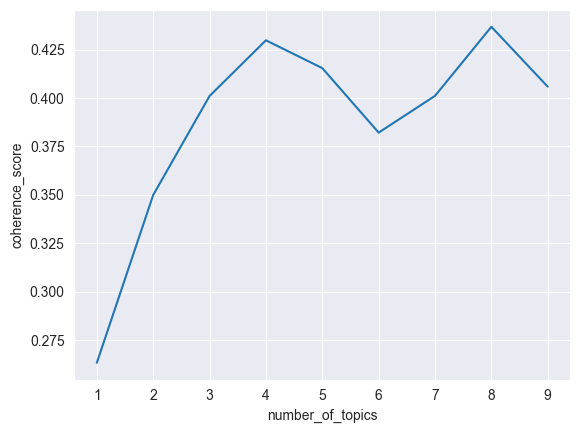

In [14]:
topic_coherence = pd.DataFrame({'number_of_topics': number_of_topics,
                                'coherence_score': coherence_score})
print(topic_coherence)
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

   number_of_topics  perplexity
0                 1   -8.956627
1                 2   -8.936681
2                 3   -8.959611
3                 4   -8.994244
4                 5   -9.108814
5                 6   -9.234168
6                 7   -9.367025
7                 8   -9.540794
8                 9   -9.740652


<Axes: xlabel='number_of_topics', ylabel='perplexity'>

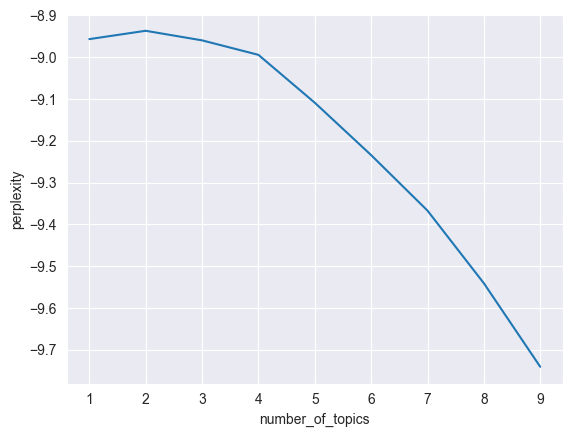

In [15]:
perplexity_result = pd.DataFrame({'number_of_topics': number_of_topics,
                                  'perplexity': perplexity_list})
print(perplexity_result)
sns.lineplot(data=perplexity_result, x='number_of_topics', y='perplexity')

In [16]:
n_topics = 4

In [26]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_topics,
    random_state=random_state,
    update_every=1,
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=150,
    per_word_topics=True,
)

print(lda_model.print_topics())

[(0, '0.010*"человек" + 0.010*"сообщать" + 0.006*"город" + 0.006*"задержать" + 0.006*"произойти" + 0.005*"сообщить" + 0.005*"находиться" + 0.005*"данные" + 0.005*"информация" + 0.005*"военный"'), (1, '0.017*"год" + 0.008*"стать" + 0.007*"первый" + 0.007*"сообщать" + 0.006*"мир" + 0.005*"новый" + 0.005*"место" + 0.005*"команда" + 0.004*"игра" + 0.004*"один"'), (2, '0.013*"россия" + 0.011*"год" + 0.010*"страна" + 0.009*"президент" + 0.009*"заявить" + 0.008*"российский" + 0.006*"глава" + 0.006*"суд" + 0.005*"сша" + 0.005*"решение"'), (3, '0.023*"год" + 0.016*"компания" + 0.014*"процент" + 0.010*"миллион" + 0.009*"доллар" + 0.009*"рубль" + 0.008*"тысяча" + 0.008*"новый" + 0.006*"система" + 0.005*"миллиард"')]


In [20]:
perplexity = lda_model.log_perplexity(corpus)
print("Perplexity:", perplexity)

Perplexity: -8.994244010075768


Ниже видно, как произошло разбиение слов на 4 темы. Группы получились примерно одинаковые по объему, группы довольно далеко удалены друг от друга, отсутствуют пересечений. Если продолжить увеличивать количество тем, становится сложно интерпретировать их, появляется много пересечений. На мой взгляд, для данного датасета 4 - оптимальное значение количества тем. 
В 1 идет речь о каких-то гос. делах, внешней политике. Во 2 идет речь о внутренних/местных новостях. В 3 говорится о рынке и экономике. 4 посвящен каким-то культурным новостям (спорт+культура).

In [44]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.279027  0.022742       1        1  29.945121
0      0.054992 -0.272899       2        1  26.019293
3      0.209400  0.090837       3        1  22.390982
1      0.014635  0.159319       4        1  21.644605, topic_info=           Term         Freq        Total Category  logprob  loglift
183    компания  2146.000000  2146.000000  Default  30.0000  30.0000
453     процент  1867.000000  1867.000000  Default  29.0000  29.0000
570   президент  1667.000000  1667.000000  Default  28.0000  28.0000
347     миллион  1403.000000  1403.000000  Default  27.0000  27.0000
463      страна  1801.000000  1801.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1415       сайт   393.878340   787.804297   Topic4  -5.7895   0.8372
313       такой   371.536071   756.803185   Topic4  -5.8479   0.8190
123   последний   375.716752   829.003705   Topic4  -5.8367   0.7390
867    получить   394.922341  1275.472417   Topic4  -5.7869   0.3580
964      летний   367.905133   833.436031   Topic4  -5.8577   0.7127

[232 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3379      2  0.997802  автомобиль
470       2  0.564825   агентство
470       3  0.419976   агентство
470       4  0.014571   агентство
2         1  0.997349     адвокат
...     ...       ...         ...
903       3  0.996877     эксперт
754       4  0.994937        этап
404       1  0.380663    являться
404       3  0.420887    являться
404       4  0.198180    являться

[293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

# BigARTM 
Установка локально была довольно забавной (Чтобы установить BigARTM, вам нужно скачать отдельный еще архивчик. Только с его помощью BigARTM поставится. После нужно поискать релиз, где были dll к данному продукту, так как в последних версиях их решили почему-то не добавлять в общий пакет. Но оно все равно не заработает, так как еще требует поставить google-cloud. После таких танцев с бубном все начнет работать. https://habr.com/ru/sandbox/182930/)
Для чистоты эксперимента для BigARTM были взяты те же самые записи из датасета. В первую очередь была обучена модель без подбора оптимального количества тем на основе перплексии, а дефолтно установлена в 4, чтобы посмотреть разницу между моделями. Использовались регуляризации с дефолтными параметрами (без подбора): сглаживание распределений терминов в темах (При использовании этой регуляризации модель будет стараться делать распределение слов в теме более равномерным, что может помочь в предотвращении переобучения и улучшении интерпретируемости тем), сглаживание распределений тем в документах (Она обеспечивает более равномерное распределение тем в документах. Это может быть полезным, когда нужно, чтобы каждый документ в коллекции был связан с различными темами, предотвращая слишком ярко выраженные предпочтения в распределении тем в документах), декоррелирование распределений терминов в темах (Эта регуляризация направлена на уменьшение корреляции между распределениями слов в разных темах. Она способствует созданию более различимых и уникальных тем, уменьшая перекрытия в словах между темами. Декоррелирование тем может помочь в создании более чистых и интерпретируемых тем в модели).

In [48]:
random.seed(random_state)
res_artm = random.sample(result, 5000)

In [49]:
res_artm = [' '.join(words_list) for words_list in res_artm]
print(res_artm[0])

слушание дело полковник юрий буданов объявить перерыв час утро май передавать риа новость вызвать судебный заседание явиться адвокат потерпевший сторона абдулл хамзай сообщить суд лейла хамзаев адвокат мать погибший чеченка настоящий абдулл хамзай находиться москва басманный суд рассматриваться иск факт разрушение дом урусмартан лейла хамзаев заявить председательствовать суд подзащитный роза башаева удаться познакомиться материал дело предыдущий судебный перерыв чувствовать плохо предложить перенести судебный слушание май защитник юрий буданов анатолий мухин поддержать просьба хамзаев прокурор присутствовать заседание согласиться мнение адвокат предложить председательствовать прибытие абдулла хамзаев ростовнадон вынести частный определение юридический консультация который представлять хамзай


In [50]:
count_vectorizer = CountVectorizer(
    max_features=5000,
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 2)
)
n_wd = np.array(count_vectorizer.fit_transform(res_artm).todense()).T

In [611]:
n_wd.shape

(5000, 5000)

In [51]:
token_list = [i for i in count_vectorizer.vocabulary_.keys()]

In [52]:
batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=token_list)

d:\bigartm-0.10.1\python\artm\batches_utils.py:227: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [53]:
def fit_model_4_topic(seed=random_state):
    model = artm.ARTM(num_topics=4, dictionary=batch_vectorizer.dictionary, cache_theta=True, seed=seed)
    model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                          dictionary=batch_vectorizer.dictionary))

    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))

    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', dictionary=batch_vectorizer.dictionary))  # сглаживание/разреживание матрицы Phi
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta'))  # сглаживание/разреживание матрицы Theta
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi'))  # сделать темы более разнообразными

    model.fit_offline(batch_vectorizer, num_collection_passes=40)
    return model

Значение перплексии получилось довольно большим

In [54]:
%%time

model_4_topics = fit_model_4_topic()
model_4_topics.score_tracker['perplexity_score'].last_value

CPU times: total: 7.78 s
Wall time: 3.04 s


1754.7264404296875

In [55]:
model_4_topics

artm.ARTM(num_topics=4, num_tokens=5000)

In [56]:
def prepare_vis_data(model):
    phi = model.get_phi()
    theta = model.get_theta().to_numpy().T
    theta[theta == 0] = np.finfo(float).eps
    theta = theta / theta.sum(axis=1, keepdims=1)
    data = {'topic_term_dists': phi.to_numpy().T,
            'doc_topic_dists': theta,
            'doc_lengths': n_wd.sum(axis=0).tolist(),
            'vocab': phi.T.columns,
            'term_frequency': n_wd.sum(axis=1).tolist()}
    return data

In [57]:
model_data_4_topics = prepare_vis_data(model_4_topics)
model_vis_4_topics = pyLDAvis.prepare(**model_data_4_topics)

Группы с темами получились примерно одного размера, но довольно сложно понять, что за тема была выделена.

In [58]:
pyLDAvis.display(model_vis_4_topics)

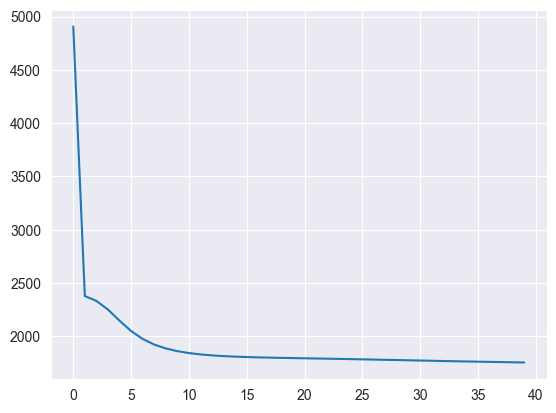

In [778]:
plt.plot(model_4_topics.score_tracker['perplexity_score'].value)

Далее был опробован метод подбора гиперпараметров. Из массива topics_to_check определялось, сколько оптимально нужно тем, чтобы модель была хороша по перплексии. Это значение оказалось довольно большим - 24 темы (последнее значение в массиве. Возможно, если было бы больше вариантов в topics_to_check, num_topics было бы еще больше)

In [59]:
def objective(space):
    model = artm.ARTM(num_topics=space['num_topics'], dictionary=batch_vectorizer.dictionary, cache_theta=True)

    model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=batch_vectorizer.dictionary))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))

    model.regularizers.add(
        artm.SmoothSparsePhiRegularizer(
            name='SparsePhi',
            tau=space['phi_tau']
        ),
    )  # Сглаживание распределений терминов в темах. Используется для выделения фоновых тем, собирающих общую лексику языка или общую лексику данной коллекции.
    model.regularizers.add(
        artm.SmoothSparseThetaRegularizer(
            name='SparseTheta',
            tau=space['theta_tau']
        ),
    )  # Сглаживание распределений тем в документах. Используется для выделения фоновых слов в каждом документах.
    model.regularizers.add(
        artm.DecorrelatorPhiRegularizer(
            name='DecorrelatorPhi',
            tau=space['decorrelation_tau']
        ),
    )  # Декоррелирование распределений терминов в темах. Используется для повышения различности лексических ядер предметных тем.

    model.fit_offline(batch_vectorizer, num_collection_passes=40)

    perplexity_score = model.score_tracker["perplexity_score"].last_value
    print("Perplexity:", perplexity_score)
    return {'loss': perplexity_score, 'status': STATUS_OK}

In [63]:
topics_to_check = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24]

In [64]:
def run_hyperparams_search():
    space = {
        'num_topics': hp.choice('num_topics', topics_to_check),
        'phi_tau': hp.uniform('SparsePhi', -1, 1),
        'theta_tau': hp.uniform('SparseTheta', -1, 1),
        'decorrelation_tau': hp.uniform('DecorrelatorPhi', 1e+2, 1e+5),
    }

    trials = Trials()

    best_hyperparams = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate = np.random.seed(random_state),
    )
    return best_hyperparams

In [65]:
%%time
best = run_hyperparams_search()

Perplexity:                                           
1253.9312744140625                                    
Perplexity:                                                                     
1561.1697998046875                                                              
Perplexity:                                                                     
1608.21240234375                                                                
Perplexity:                                                                     
1280.426025390625                                                               
Perplexity:                                                                     
1598.168701171875                                                               
Perplexity:                                                                     
2081.366455078125                                                               
Perplexity:                                                                     

In [770]:
best

{'DecorrelatorPhi': 13725.437070904656,
 'SparsePhi': -0.03672595705442432,
 'SparseTheta': -0.9130682558102625,
 'num_topics': 15}

In [771]:
def fit_model(seed=random_state):
    model = artm.ARTM(num_topics=topics_to_check[best['num_topics']], dictionary=batch_vectorizer.dictionary, cache_theta=True, seed=seed)
    model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                          dictionary=batch_vectorizer.dictionary))

    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))

    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=best[
        'SparsePhi']))  # сглаживание/разреживание матрицы Phi
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=best[
        'SparseTheta']))  # сглаживание/разреживание матрицы Theta
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=best[
        'DecorrelatorPhi']))  # сделать темы более разнообразными

    model.fit_offline(batch_vectorizer, num_collection_passes=40)
    return model

In [772]:
%%time

model = fit_model()
model.score_tracker['perplexity_score'].last_value

CPU times: total: 10.5 s
Wall time: 4.63 s


1099.1373291015625

In [776]:
model_data = prepare_vis_data(model)
model_vis = pyLDAvis.prepare(**model_data)

D:\Katerina\Новая папка\Del\venv\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
D:\Katerina\Новая папка\Del\venv\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
D:\Katerina\Новая папка\Del\venv\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Группы так же получились примерно одного размера, но здесь наблюдаются цже пересечения, что не очень бывает хорошо. Так же сложно тем распознать. Возможно, для хорошего качества для данной модели нужно сильно больше данных.

In [777]:
pyLDAvis.display(model_vis)

Если судить по метрикам, то все выглядит неплохо. perplexity_score упал; sparsity_phi_score должен стремиться к 1 (измеряет разреженность (спарсность) распределения слов внутри каждой темы. Эта метрика показывает, насколько каждая тема связана только с небольшим подмножеством слов. Чем ближе значение SparsityPhiScore к 1, тем более разреженными являются распределения слов в каждой теме.), что и происходит; sparsity_theta_score стремится к 1 ((SparsityThetaScore измеряет разреженность (спарсность) распределений тем в документах. Эта метрика показывает, насколько каждый документ связан с небольшим числом тем. Чем ближе значение SparsityThetaScore к 1, тем более разреженными являются распределения тем в документах.).

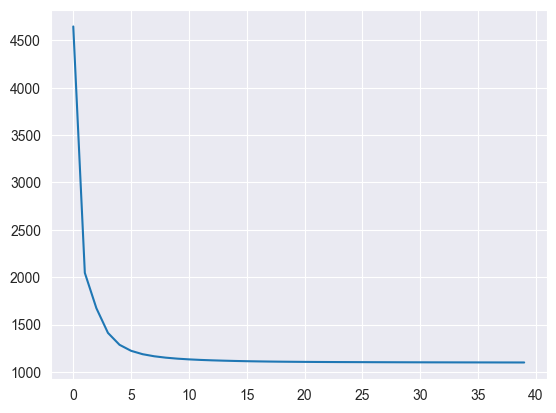

In [781]:
plt.plot(model.score_tracker['perplexity_score'].value)

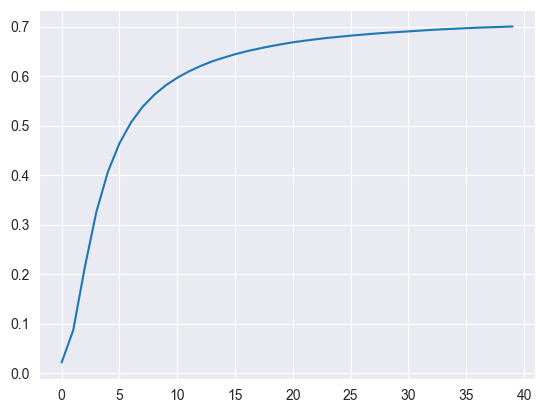

In [782]:
plt.plot(model.score_tracker['sparsity_phi_score'].value)

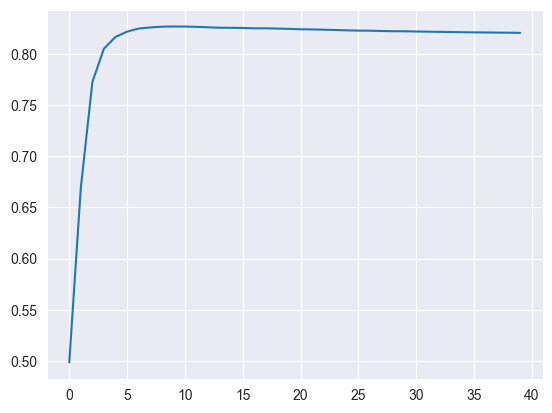

In [783]:
plt.plot(model.score_tracker['sparsity_theta_score'].value)